In [13]:
# print(f"{__file__} imported")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sn

def get_norm_layer( norm_layer_type, num_channels, num_groups_for_group_norm=None):
    """
    norm_layer_type: 'batch' | 'group' | 'layer'
    num_channels: # of channels
    """
    if norm_layer_type == "batch":
       
        nl = nn.BatchNorm2d(num_features=num_channels)
    elif norm_layer_type == "group":
        nl = nn.GroupNorm(num_groups=num_groups_for_group_norm, num_channels=num_channels)
    elif norm_layer_type == "layer":
       
        nl = nn.GroupNorm(num_groups=1, num_channels=num_channels)

    return nl

class Net(nn.Module):
    def __init__(self, norm_layer_type, num_groups_for_group_norm=None):
        """
        normalization_type: 'batch' | 'group' | 'layer'
        """
        super(Net, self).__init__()
        
        dropout=0.05
 
        ####### 
        # Convolution Block #1
        #########
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False)),
            ('relu', nn.ReLU()),
            ('batchNorm2d', get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm) ),
            ('dropOut2d', nn.Dropout2d(p=dropout))
          ])
        ) # Input=28, Output=28, rf=3

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=28, Output=28, rf=5
 
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=28, Output=28, rf=10
 
        ####### 
        # Transition Block #1
        #########
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Input=28, Output=14, rf=6
 
        self.conv4= nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=1, padding=0, bias=False),
        ) # Input=14, Output=14, rf=32
 
        ####### 
        # Convolution Block #2
        #########
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=14, Output=14, rf=14
 
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        )# Input=14, Output=14, rf=24
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=10, num_groups_for_group_norm=num_groups_for_group_norm),
            #nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24
        
        #######
        # Transition block #2
        #######
        self.maxpool2= nn.MaxPool2d(kernel_size=2, stride=2) # Input=6, Output=3, chan=12, 
 
        ####### 
        # Output Block
        #########
        # global average pool before 1x1 to reduce computation
        #self.global_avgpool = nn.AdaptiveAvgPool2d(output_size=1)  # Input=3, Output=1, chan=12,
        self.global_avgpool = nn.AvgPool2d(kernel_size=10)  # Input=3, Output=1, chan=12,
 
        self.conv10 = nn.Sequential(
            
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=1, padding=0, bias=False),
        ) # Input=1, Output=1, chan=10, 
    
    def forward(self, x):
        #####
        # conv block #1
        ########
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
 
        #####
        # Transitioni block #1
        ########
        x = self.maxpool1(x)
        x = self.conv4(x)
 
        #####
        # conv block #2
        ########
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)

        #######
        # Transition block #2
        #######
        #x = self.maxpool2(x)
 
        #####
        # output block
        ########
        x = self.global_avgpool(x)        
        #x = self.conv10_16_1_1_10(x)
               
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from collections import OrderedDict
import os
import sys
import shutil
import glob
import pdb


In [3]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net('batch').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
      BatchNorm2d-11            [-1, 8, 28, 28]              16
        Dropout2d-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
# SEED=1 so that we use the same random images for training, during each mini batch, during each epoch
SEED=1
torch.manual_seed(SEED)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# download training data set: 50,000 images
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# download test data set: 10,000 images
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Train data function

In [5]:
class Train():
    """
    Model training is performed considering the multiple inputs like
    model, device on which training has to happen, optimizer to be
    used while training.

    Parameters:
    -----------
    model: Model architecture to be used to train the model.
    device: Type of device (GPU/CPU) to be used while training model.
    train_loader: Defining which DataLoader to be used for training.
    optimizer: Defining which optimizer to be used.

    Returns:
    --------
    train_loss: The loss observed while training the model.
    accuracy: Accuracy of the model over the current training data.
    """
    def __init__(self, model, device, train_loader, optimizer, is_l1=False, **kwargs):

        self.model = model
        self.progress_bar = tqdm(train_loader)
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.device = device
        self.is_l1 = is_l1
        if self.is_l1:
            self.lambda_l1 = kwargs.get("lambda_l1")

        self.accuracy = []
        self.loss = []


    def __call__(self):
        self.model.train() 
        correct_count = 0
        train_loss = 0
        for batch_idx, (data, target) in enumerate(self.progress_bar):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()  # Setting optimizer value to zero to avoid accumulation of gradient values
            output = self.model(data)
            batch_loss = F.nll_loss(input=output, target=target, reduction='mean')
            if self.is_l1:
                l1 = 0
                for p in self.model.parameters():
                    l1 += p.abs().sum()
                batch_loss = batch_loss + self.lambda_l1 * l1
            batch_loss.backward()
            self.optimizer.step()

            train_loss += batch_loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_count += pred.eq(target.view_as(pred)).sum().item()

            self.progress_bar.set_description(desc= f'loss={batch_loss.item()} batch_id={batch_idx}')
            
        train_loss /= len(self.train_loader)
        accuracy = 100. * correct_count / len(self.train_loader.dataset)

        self.loss.append(train_loss)
        self.accuracy.append(accuracy)
        
        return train_loss, accuracy

### Test Data function

In [6]:
class Test():
    """
    Performance of the trained model is evaluated on the DataLoader provided by
    the user.

    Parameters:
    -----------
    model: Model to be used to test the model.
    device: Type of device (GPU/CPU) to be used while testing model.
    test_loader: Defining which DataLoader to be used for testing.

    Returns:
    --------
    test_loss: The loss observed while testing the model.
    accuracy: Accuracy of the model over the testing data.
    """
    def __init__(self, model, device, test_loader):

        self.model = model
        self.test_loader = test_loader
        self.device = device
        
        self.loss = []
        self.accuracy = []

    def __call__(self):
        self.model.eval()
        correct_count = 0
        test_loss = 0
        with torch.no_grad():  # Setting the calculations to not involve any kind of gradient calculation
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.nll_loss(output, target, reduction='mean').item()
                pred = output.argmax(dim=1) # Getting Indices of Class with Max Value for each Image
                correct_count += pred.eq(target).sum().item() # Equating Predicted and Label Tensors at each Index value

        test_loss /= len(self.test_loader)
        accuracy = 100. * correct_count / len(self.test_loader.dataset)

        self.loss.append(test_loss)
        self.accuracy.append(accuracy)

        return test_loss, accuracy

### Plotting data functions 

In [7]:
def plot_loss_acc(train_loss, train_acc, test_loss, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_loss)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_loss)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


def plot_combined(train_acc, test_acc, x_label='epochs', y_label='Accuracy'):
    plt.axes(xlabel= x_label, ylabel= y_label)
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title('Test vs Train')
    plt.legend(['Train', 'Test'])


def data_stats(data):
    exp = data.data
    exp = data.transform(exp.numpy())

    print('Train Statistics')
    print(' - Numpy Shape:', data.data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.data.size())
    print(' - min:', torch.min(exp))
    print(' - max:', torch.max(exp))
    print(' - mean:', torch.mean(exp))
    print(' - std:', torch.std(exp))
    print(' - var:', torch.var(exp))

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def plot_data_grid(train_loader, mean:list, std:list, class_list, ncol=5, nrow=2):

    images, labels = next(iter(train_loader))
    unNorm= UnNormalize(mean, std)

    fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
    for num in range(nrow*ncol):
        i = num//nrow
        j = num%ncol
        if images[num].size(0) == 1: #Single Channel
            img = unNorm(images[num])
            img = torch.squeeze(img,0)
            cmap='gray'
        else: # Multi-Channel
            img = unNorm(images[num])
            img = np.transpose(img, (1,2,0))
            cmap=None
        a[i][j].imshow(img, cmap)
        a[i][j].set_title(f'GT:{class_list[labels[num]]}')
        a[i,j].axis('off')
    fig.tight_layout()


class Results():

    def __init__(self, model, loader, device, mean, std, class_list):
        self.model = model
        self.loader = loader
        self.device = device
        self.mean = mean
        self.std = std
        self.class_list = class_list
        self.results = self._forwad_pass()

    def _forwad_pass(self):
        nb_classes = len(self.class_list)
        confusion_matrix = torch.zeros(nb_classes, nb_classes, dtype=torch.long)
        pred_imgs, pred_lab, gt_lab = None, None, None
        incorrect_images, total_pred, total_gt_lab = None, None, None

        self.model.eval()
        with torch.no_grad():
            for batch in self.loader:
                images, labels = batch
                output = self.model(images.to(self.device))
                predicted = output.argmax(dim=1).cpu()

                # Confusion Matrix
                for l,p in zip(labels, predicted):
                    confusion_matrix[l, p] += 1

                # For Plot Results of one Batch
                if pred_imgs is None:
                    pred_imgs = images
                    pred_lab = predicted.cpu()
                    gt_lab = labels

                # Geeting the ids of "In"correct Classigied Images
                idx = ~predicted.eq(labels)
                if idx.sum().item() > 0: # If there are incorrect images
                    if incorrect_images is None:
                        incorrect_images = images[idx]
                        total_pred = predicted[idx]
                        total_gt_lab = labels[[idx]]
                    else:
                        incorrect_images = torch.cat((incorrect_images, images[idx]), dim=0)
                        total_pred = torch.cat((total_pred, predicted[idx].cpu()))
                        total_gt_lab = torch.cat((total_gt_lab, labels[[idx]]))

        cls_acc = (confusion_matrix.diag()/confusion_matrix.sum(1))*100

        return {'confusion':confusion_matrix, 'class_acc': cls_acc, 
                'incorrect_images':incorrect_images, 'total_pred': total_pred, 'total_gt':total_gt_lab,
                'pred_imgs':pred_imgs, 'pred_lab':pred_lab, 'gt_lab':gt_lab}

    def plot_batch(self, ncol=6, nrow=6):
        
        unNorm= UnNormalize(self.mean, self.std)

        fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
        for num in range(nrow*ncol):
            i = num//nrow
            j = num%ncol
            if self.results['pred_imgs'][num].size(0) == 1: #Single Channel
                img = unNorm(self.results['pred_imgs'][num])
                img = torch.squeeze(img,0)
                cmap='gray'
            else: # Multi-Channel
                img = unNorm(self.results['pred_imgs'][num])
                img = np.transpose(img, (1,2,0))
                cmap=None
            a[i][j].imshow(img, cmap)
            a[i][j].set_title(f"GT:{self.class_list[self.results['gt_lab'][num]]}")
            a[i][j].text(0.5,-0.2, f"Predicted: {self.class_list[self.results['pred_lab'][num].item()]}", size=12, ha="center", transform=a[i][j].transAxes)
            a[i][j].axis('off')

        fig.tight_layout()

    def plot_incorrect(self, nrow, ncol):
        '''
        Plot those Incorrect classified Images in ncol*nrow matrix if given,
        or else Displays all incorrect classified Images.
        Parameters:
            nrow: The Number of Rows of Images
            ncol: The Number of Coloumns of Images
        '''
        unNorm= UnNormalize(self.mean, self.std)
        ncol_ = int(np.sqrt(self.results['incorrect_images'].size(0))) #Finding Total Number of Images Sqrt
        
        # All Images or Given ncol*nrow number of Images
        ncol = ncol
        nrow = nrow

        num = 0
        fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
        for i in range(nrow):
            for j in range(ncol):
                if self.results['incorrect_images'][num].size(0) == 1: #Single Channel
                    img = unNorm(self.results['incorrect_images'][num])
                    img = torch.squeeze(img,0)
                    cmap='gray'
                else: # Multi-Channel
                    img = unNorm(self.results['incorrect_images'][num])
                    img = np.transpose(img, (1,2,0))
                    cmap=None
                a[i][j].imshow(img, cmap)
                a[i][j].set_title(f"GT:{self.class_list[self.results['total_gt'][num]]}")
                a[i][j].text(0.5,-0.2, f"Predicted: {self.class_list[self.results['total_pred'][num].item()]}", size=12, ha="center", transform=a[i][j].transAxes)
                a[i][j].axis('off')
                num += 1

        fig.tight_layout()

    def class_accuracy(self, confusion_heatmap=True, top_n=10):
        '''

        '''
        if confusion_heatmap:
            plt.figure(figsize=(8,8))
            sn.heatmap(self.results['confusion'].numpy(), 
                        xticklabels=self.class_list, yticklabels=self.class_list,
                        annot=True,cmap='Blues', fmt='d')
            plt.xlabel("Predicted") 
            plt.ylabel("Labels") 
            plt.show()
        
        sorted_class_acc = torch.sort(self.results['class_acc'])
        
        print(f'Accuracies of Top {top_n} Classes in Decreasing Order')
        for i in sorted_class_acc.indices[:top_n]:
            print(f"Accuracy of class {self.class_list[i]} is {self.results['class_acc'][i]:.2f}")

In [10]:
from torch.optim.lr_scheduler import StepLR

model_bn = Net('batch').to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_bn = Train(model_bn, device, train_loader, optimizer, is_l1=True, lambda_l1=0.00005)
tester_bn = Test(model_bn, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_bn()
    scheduler.step()
    test_loss, test_acc = tester_bn()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1


loss=0.35514330863952637 batch_id=468: 100%|██████████| 469/469 [01:24<00:00,  5.57it/s]


TRAIN set: Average loss: 0.6959, Train Accuracy: 83.20% | TEST set: Average loss: 0.1203, Test Accuracy: 97.36%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.2514, Train Accuracy: 94.70% | TEST set: Average loss: 0.0694, Test Accuracy: 98.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.1966, Train Accuracy: 95.80% | TEST set: Average loss: 0.0638, Test Accuracy: 98.23%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.1713, Train Accuracy: 96.39% | TEST set: Average loss: 0.0487, Test Accuracy: 98.65%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.1542, Train Accuracy: 96.75% | TEST set: Average loss: 0.0481, Test Accuracy: 98.66%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.1488, Train Accuracy: 96.86% | TEST set: Average loss: 0.0405, Test Accur

In [11]:

print('Train Accuracy:', max(trainer_bn.accuracy))
print('Test Accuracy:', max(tester_bn.accuracy))

Train Accuracy: 97.785
Test Accuracy: 99.13


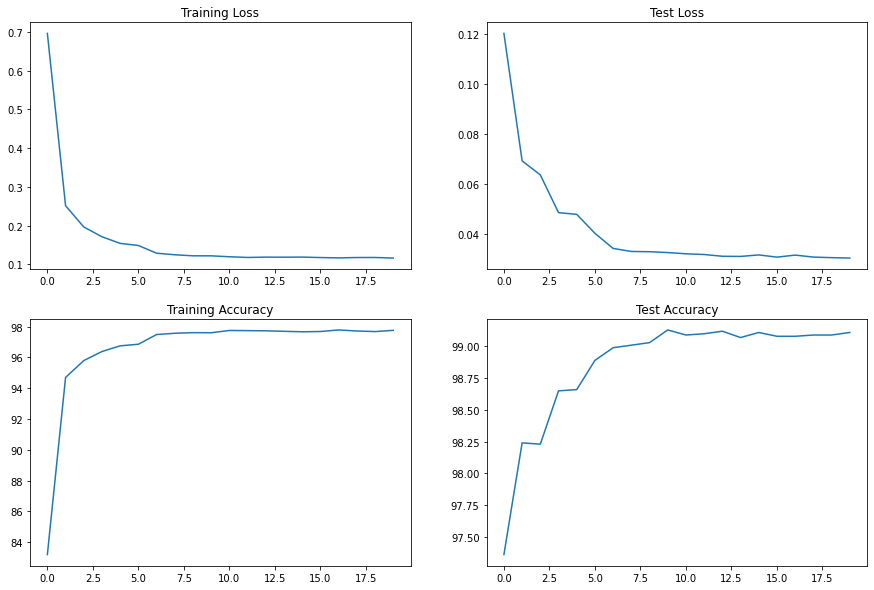

In [14]:
plot_loss_acc(trainer_bn.loss, trainer_bn.accuracy, tester_bn.loss, tester_bn.accuracy)

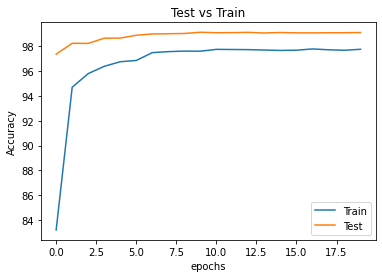

In [15]:
plot_combined(trainer_bn.accuracy, tester_bn.accuracy,  x_label='epochs', y_label='Accuracy')

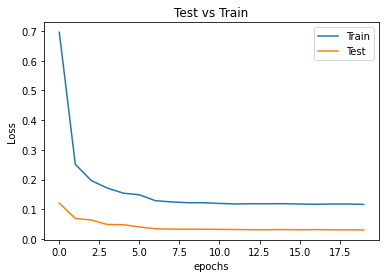

In [16]:

plot_combined(trainer_bn.loss, tester_bn.loss,  x_label='epochs', y_label='Loss')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


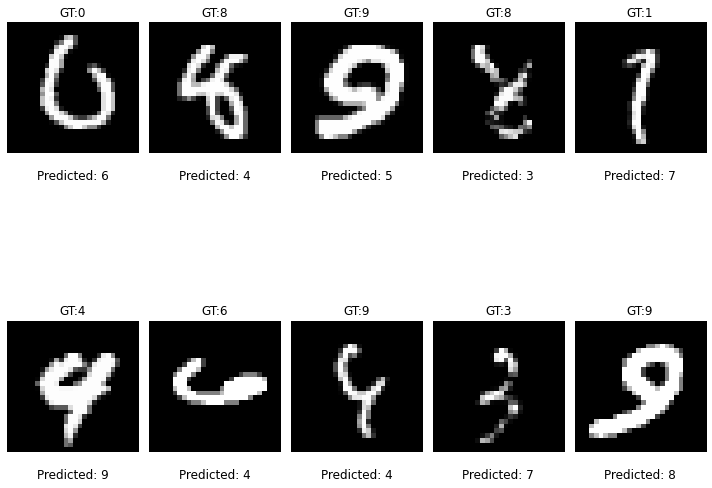

In [18]:

class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_bn = Results(model_bn, test_loader, device, mean, std, class_list)
results_bn.plot_incorrect(2, 5)

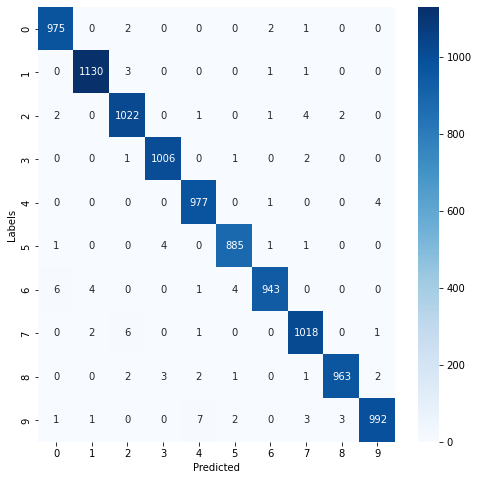

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 9 is 98.32
Accuracy of class 6 is 98.43
Accuracy of class 8 is 98.87
Accuracy of class 7 is 99.03
Accuracy of class 2 is 99.03
Accuracy of class 5 is 99.22
Accuracy of class 0 is 99.49
Accuracy of class 4 is 99.49
Accuracy of class 1 is 99.56
Accuracy of class 3 is 99.60


In [19]:
results_bn.class_accuracy()

### GROUP NORMALIZATION

In [21]:
model_gn = Net('batch').to(device)
summary(model_gn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
      BatchNorm2d-11            [-1, 8, 28, 28]              16
        Dropout2d-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [24]:
from torch.optim.lr_scheduler import StepLR


optimizer = optim.SGD(model_gn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_gn = Train(model_gn, device, train_loader, optimizer)
tester_gn = Test(model_gn, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_gn()
    scheduler.step()
    test_loss, test_acc = tester_gn()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

loss=0.0571858212351799 batch_id=0:   0%|          | 1/469 [00:00<01:22,  5.70it/s]

Epoch: 1


loss=0.061755795031785965 batch_id=468: 100%|██████████| 469/469 [01:22<00:00,  5.67it/s]


TRAIN set: Average loss: 0.1057, Train Accuracy: 97.22% | TEST set: Average loss: 0.0409, Test Accuracy: 98.78%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.1017, Train Accuracy: 97.24% | TEST set: Average loss: 0.0398, Test Accuracy: 98.83%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0945, Train Accuracy: 97.52% | TEST set: Average loss: 0.0341, Test Accuracy: 99.03%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0904, Train Accuracy: 97.62% | TEST set: Average loss: 0.0360, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0884, Train Accuracy: 97.53% | TEST set: Average loss: 0.0374, Test Accuracy: 98.90%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0844, Train Accuracy: 97.71% | TEST set: Average loss: 0.0320, Test Accur

In [25]:
print('Train Accuracy:', max(trainer_gn.accuracy))
print('Test Accuracy:', max(tester_gn.accuracy))

Train Accuracy: 98.22333333333333
Test Accuracy: 99.21


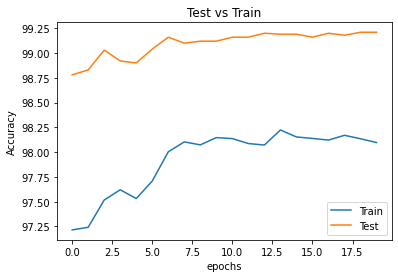

In [26]:
plot_combined(trainer_gn.accuracy, tester_gn.accuracy,  x_label='epochs', y_label='Accuracy')

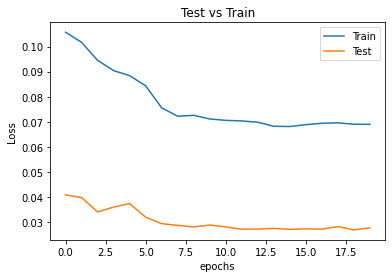

In [27]:
plot_combined(trainer_gn.loss, tester_gn.loss,  x_label='epochs', y_label='Loss')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


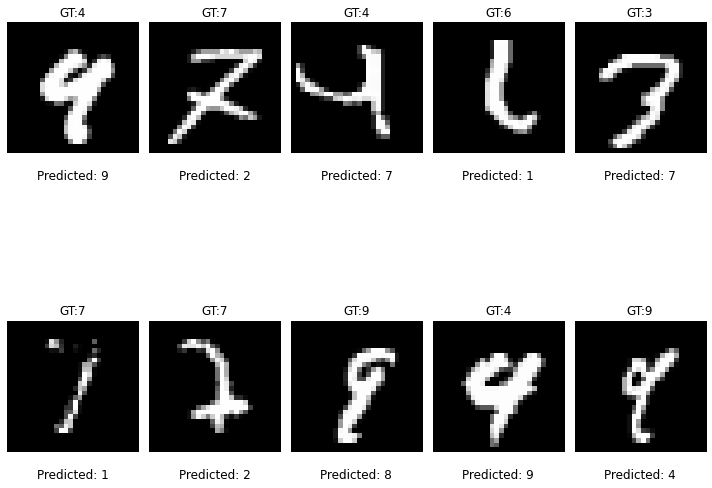

In [28]:

class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_gn = Results(model_gn, test_loader, device, mean, std, class_list)
results_gn.plot_incorrect(2, 5)

In [29]:
model_ln = Net('layer').to(device)
summary(model_ln, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         GroupNorm-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
        GroupNorm-11            [-1, 8, 28, 28]              16
        Dropout2d-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [31]:
from torch.optim.lr_scheduler import StepLR


optimizer = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_ln = Train(model_ln, device, train_loader, optimizer)
tester_ln = Test(model_ln, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_ln()
    scheduler.step()
    test_loss, test_acc = tester_ln()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

loss=2.4216771125793457 batch_id=0:   0%|          | 1/469 [00:00<01:10,  6.66it/s]

Epoch: 1


loss=0.282284677028656 batch_id=468: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]


TRAIN set: Average loss: 0.7318, Train Accuracy: 80.41% | TEST set: Average loss: 0.1196, Test Accuracy: 96.64%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.2170, Train Accuracy: 94.50% | TEST set: Average loss: 0.0812, Test Accuracy: 97.66%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.1557, Train Accuracy: 95.90% | TEST set: Average loss: 0.0573, Test Accuracy: 98.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.1313, Train Accuracy: 96.46% | TEST set: Average loss: 0.0556, Test Accuracy: 98.22%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.1141, Train Accuracy: 96.88% | TEST set: Average loss: 0.0455, Test Accuracy: 98.75%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.1057, Train Accuracy: 97.09% | TEST set: Average loss: 0.0478, Test Accur

In [32]:

print('Train Accuracy:', max(trainer_ln.accuracy))
print('Test Accuracy:', max(tester_ln.accuracy))

Train Accuracy: 98.025
Test Accuracy: 99.12


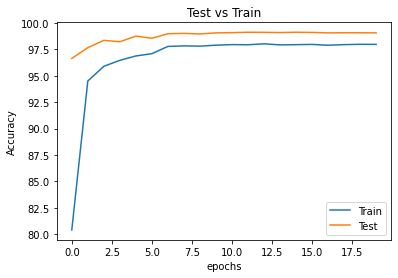

In [33]:
plot_combined(trainer_ln.accuracy, tester_ln.accuracy,  x_label='epochs', y_label='Accuracy')

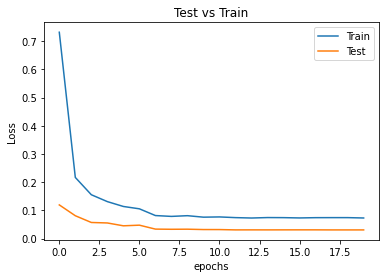

In [34]:

plot_combined(trainer_ln.loss, tester_ln.loss,  x_label='epochs', y_label='Loss')

In [35]:

class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_ln = Results(model_ln, test_loader, device, mean, std, class_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


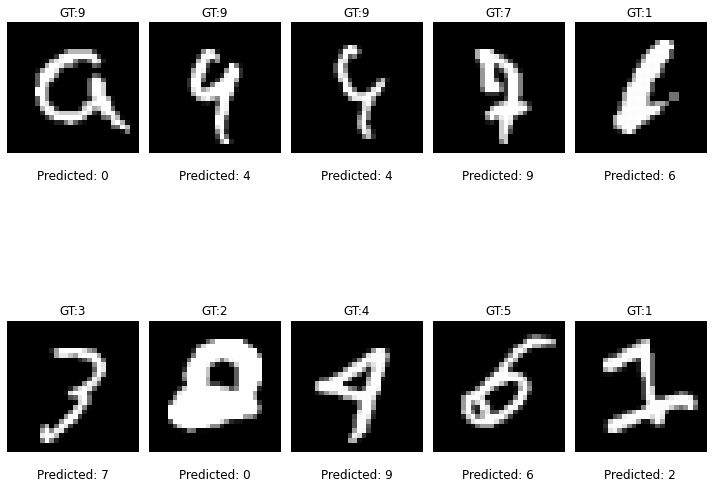

In [36]:
results_ln.plot_incorrect(2, 5)

In [37]:
def plot_combined(list_of_plotters, *, x_label='epochs', y_label='Accuracy', title='Test vs Train', legend = ['Train', "Test"]):
    '''
    Plot multiple list of values, in a single plot.
    Parameters:
        list_of_plotters: A List of Accuracies/Loss which are arrays/lists.
        x_label: The X Axis Label (Optional Keywork Argument)
        y_label: The Y Axis Label (Optional Keywork Argument)
        title: The Title of the Graph (Optional Keywork Argument)
        legend: The Legend to be printed on Chart (Optional Keywork Argument) 
    '''
    plt.axes(xlabel= x_label, ylabel= y_label)
    for plotting_list in list_of_plotters:
        plt.plot(plotting_list)
    plt.title(title)
    plt.legend(legend)

In [38]:
list_test_acc = [tester_bn.accuracy, tester_gn.accuracy, tester_ln.accuracy]
list_test_loss = [tester_bn.loss, tester_gn.loss, tester_ln.loss]

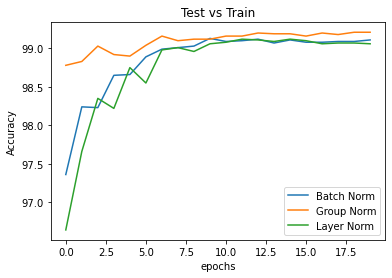

In [39]:
plot_combined(list_test_acc, legend=["Batch Norm", "Group Norm", "Layer Norm"])

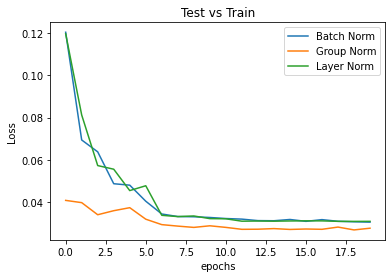

In [40]:

plot_combined(list_test_loss, legend=["Batch Norm", "Group Norm", "Layer Norm"], y_label="Loss")